# Implementation of QAOA

### getting portfolio

In [45]:
import yfinance as yf
import pandas as pd

import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from collections import defaultdict
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

In [46]:
tickers = ['GLD', '^GSPC']
data = yf.download(tickers, start='2005-01-01', end='2025-01-01')

[*********************100%***********************]  2 of 2 completed


In [47]:
data.head()

Price           Close                    High                     Low  \
Ticker            GLD        ^GSPC        GLD        ^GSPC        GLD   
Date                                                                    
2005-01-03  43.020000  1202.079956  43.169998  1217.800049  42.740002   
2005-01-04  42.740002  1188.050049  42.910000  1205.839966  42.459999   
2005-01-05  42.669998  1183.739990  42.880001  1192.729980  42.599998   
2005-01-06  42.150002  1187.890015  42.560001  1191.630005  42.070000   
2005-01-07  41.840000  1186.189941  42.389999  1192.199951  41.700001   

Price                         Open                Volume              
Ticker            ^GSPC        GLD        ^GSPC      GLD       ^GSPC  
Date                                                                  
2005-01-03  1200.319946  42.980000  1211.920044  4750400  1510800000  
2005-01-04  1185.390015  42.799999  1202.079956  3456800  1721000000  
2005-01-05  1183.719971  42.750000  1188.050049  2033600  1738900000  
2005-01-06  1183.270020  42.480000  1183.739990  2556400  1569100000  
2005-01-07  1182.160034  42.090000  1187.890015  4492700  1477900000

In [48]:
close_prices = data['Close']
daily_returns = close_prices.pct_change().dropna()*100 #  ( Pt − Pt-1 ) / Pt−1

In [49]:
daily_returns.head()

Ticker,GLD,^GSPC
Date,,
2005-01-04,-0.650857,-1.167136
2005-01-05,-0.163789,-0.362784
2005-01-06,-1.218647,0.350586
2005-01-07,-0.735472,-0.143117
2005-01-10,0.262908,0.342277


In [5]:
daily_returns.mean()

Ticker
GLD      0.040458
^GSPC    0.038870
dtype: float64

In [50]:
# Mean daily return for each asset
mean_daily_returns = daily_returns.mean()

# (Optional) Annualize if you want yearly return estimates
trading_days = 252
annualized_returns = mean_daily_returns * trading_days

# Convert to list for your QUBO code
returns_list = annualized_returns.to_numpy().tolist()

In [51]:
returns_list = daily_returns.mean().to_numpy().tolist()
returns_list

[0.04045768843899977, 0.03887037743039809]

In [53]:
cov_stocks=daily_returns.cov()
cov_stocks

Ticker,GLD,^GSPC
Ticker,,
GLD,1.221527,0.076211
^GSPC,0.076211,1.458465


In [9]:
list(cov_stocks.index)

['GLD', '^GSPC']

In [10]:
#data.round(2) # Round the data upto two decimal places

In [55]:
cov_matrix = cov_stocks.round(3).to_numpy()

# Define tickers for readability
tickers = ['BAC', 'GS', 'JPM', 'MS']
tickers = list(cov_stocks.index)

# Define the number of assets
n_assets = len(tickers)

# Define the number of binary variables per asset
# This determines the granularity of allocation (e.g., 3 bits = 8 levels)
bits_per_asset = 3

# Define budget constraint (e.g., total allocation = 100%)
budget = 1.0

# Define lambda parameter for constraints
lambd = 10.0  # Adjust based on the importance of constraints

In [56]:
[2**(-i-1) for i in range(3)][::-1]

[0.125, 0.25, 0.5]

In [57]:
def construct_portfolio_qubo(cov_matrix, n_assets, bits_per_asset, budget, returns, return_coeff, lambd):
    """
    Construct the QUBO matrix for portfolio optimization.
    
    Parameters:
    - cov_matrix: Covariance matrix of assets
    - n_assets: Number of assets
    - bits_per_asset: Number of binary variables per asset
    - budget: Total budget constraint (usually 1.0 for 100%)
    - lambd: Penalty parameter for constraints
    
    Returns:
    - Q: QUBO matrix
    """
    total_qubits = n_assets * bits_per_asset
    Q = np.zeros((total_qubits, total_qubits))
    
    # Define the weights for binary encoding (e.g., [0.125, 0.25, 0.5] for 3 bits)
    weights = [2**(-i-1) for i in range(bits_per_asset)][::-1]
    
    # Objective function: minimize portfolio variance
    for i in range(n_assets):
        for j in range(n_assets):
            for bi in range(bits_per_asset):
                for bj in range(bits_per_asset):
                    # Index in the Q matrix
                    idx_i = i * bits_per_asset + bi
                    idx_j = j * bits_per_asset + bj
                    
                    # Weight of this binary variable combination
                    weight_i = weights[bi]
                    weight_j = weights[bj]
                    
                    # Add to QUBO matrix (objective is to minimize risk)
                    Q[idx_i, idx_j] += cov_matrix[i, j] * weight_i * weight_j
    
    # Budget constraint: sum of all allocations should equal budget
    # We add a penalty term: λ(sum(weights*x) - budget)^2
    
    # First, expand the squared term
    # (sum(weights*x) - budget)^2 = (sum(weights*x))^2 - 2*budget*sum(weights*x) + budget^2
    
    # The budget^2 term is constant and can be ignored
    
    # For the (sum(weights*x))^2 term:
    for i in range(n_assets):
        for bi in range(bits_per_asset):
            for j in range(n_assets):
                for bj in range(bits_per_asset):
                    idx_i = i * bits_per_asset + bi
                    idx_j = j * bits_per_asset + bj
                    weight_i = weights[bi]
                    weight_j = weights[bj]
                    Q[idx_i, idx_j] += lambd * weight_i * weight_j
    
    # For the -2*budget*sum(weights*x) term and return maximization:
    for i in range(n_assets):
        for bi in range(bits_per_asset):
            idx = i * bits_per_asset + bi
            weight = weights[bi]
            Q[idx, idx] -= 2 * lambd * budget * weight

            # Subtract because we want to maximize return
            Q[idx, idx] -= return_coeff * returns[i] * weight        
    
    return Q

# -----------------------------   QAOA circuit ------------------------------------
def qaoa_circuit(gammas, betas, h, J, num_qubits):
    """
    Create a QAOA circuit in Qiskit.
    
    Parameters:
    - gammas: Parameters for the cost Hamiltonian
    - betas: Parameters for the mixer Hamiltonian
    - h: Dictionary of single-qubit terms
    - J: Dictionary of two-qubit interaction terms
    - num_qubits: Number of qubits in the circuit
    
    Returns:
    - qc: Quantum circuit implementing QAOA
    """
    p = len(gammas)
    wmax = max(
        np.max(np.abs(list(h.values()))), np.max(np.abs(list(J.values())))
    )  # Normalizing the Hamiltonian
    
    # Create a quantum circuit with num_qubits qubits
    qc = QuantumCircuit(num_qubits, num_qubits)
    
    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        qc.h(i)
    
    # Repeat p layers of the QAOA circuit
    for layer in range(p):
        # ---------- COST HAMILTONIAN ----------
        for ki, v in h.items():  # single-qubit terms
            qc.rz(2 * gammas[layer] * v / wmax, ki[0])
        
        for kij, vij in J.items():  # two-qubit terms
            qc.cx(kij[0], kij[1])
            qc.rz(2 * gammas[layer] * vij / wmax, kij[1])
            qc.cx(kij[0], kij[1])
        
        # ---------- MIXER HAMILTONIAN ----------
        for i in range(num_qubits):
            qc.rx(-2 * betas[layer], i)
    
    # Measure all qubits
    qc.measure(range(num_qubits), range(num_qubits))
    
    return qc

def from_Q_to_Ising(Q, offset):
    """
    Convert the QUBO matrix Q into Ising model parameters.
    
    Parameters:
    - Q: QUBO matrix
    - offset: Initial offset value
    
    Returns:
    - h: Dictionary of single-qubit terms
    - J: Dictionary of two-qubit interaction terms
    - offset: Updated offset value
    """
    n_qubits = len(Q)
    h = defaultdict(int)
    J = defaultdict(int)
    
    for i in range(n_qubits):
        h[(i,)] -= Q[i, i] / 2
        offset += Q[i, i] / 2
        
        for j in range(i + 1, n_qubits):
            J[(i, j)] += Q[i, j] / 4
            h[(i,)] -= Q[i, j] / 4
            h[(j,)] -= Q[i, j] / 4
            offset += Q[i, j] / 4
            
    return h, J, offset

In [58]:
# Construct the QUBO matrix
Q = construct_portfolio_qubo(cov_matrix, n_assets, bits_per_asset,
                             budget, returns_list, 2, lambd)
print(Q)

[[-2.33477067  0.3506875   0.701375    0.1574375   0.314875    0.62975   ]
 [ 0.3506875  -4.31885384  1.40275     0.314875    0.62975     1.2595    ]
 [ 0.701375    1.40275    -7.23495769  0.62975     1.2595      2.519     ]
 [ 0.1574375   0.314875    0.62975    -2.33068634  0.3580625   0.716125  ]
 [ 0.314875    0.62975     1.2595      0.3580625  -4.30331019  1.43225   ]
 [ 0.62975     1.2595      2.519       0.716125    1.43225    -7.17437038]]


In [ ]:
offset = 0  # We can start with zero offset


In [68]:
# Encode the QUBO as a quantum Hamiltonian
h, J, offset = from_Q_to_Ising(Q, offset)

# QAOA parameters
p = 5  # Number of QAOA layers
gammas = np.linspace(0.1, 1.0, p)  # Parameters for cost Hamiltonian
betas = np.linspace(0.1, 0.8, p)[::-1]  # Parameters for mixer Hamiltonian
total_qubits = n_assets * bits_per_asset

# Create the QAOA circuit
qc = qaoa_circuit(gammas, betas, h, J, total_qubits)

In [31]:


# Run the circuit
simulator = AerSimulator()
result = simulator.run(qc, shots=10000).result()
counts = result.get_counts()

In [18]:
def decode_portfolio_allocation(bitstring, n_assets, bits_per_asset):
    """
    Decode a bitstring into portfolio allocations.
    
    Parameters:
    - bitstring: Binary string from measurement
    - n_assets: Number of assets
    - bits_per_asset: Number of binary variables per asset
    
    Returns:
    - allocations: Dictionary mapping asset indices to allocation percentages
    """
    # Reverse the bitstring to match the expected format
    bitstring = bitstring[::-1]
    
    allocations = {}
    weights = [2**(-i-1) for i in range(bits_per_asset)][::-1]
    
    for i in range(n_assets):
        asset_bits = bitstring[i*bits_per_asset:(i+1)*bits_per_asset]
        allocation = sum(int(bit) * weight for bit, weight in zip(asset_bits, weights))
        allocations[i] = allocation
    
    return allocations

def calculate_portfolio_risk(allocations, cov_matrix):
    """
    Calculate the portfolio risk given allocations.
    
    Parameters:
    - allocations: Dictionary mapping asset indices to allocation percentages
    - cov_matrix: Covariance matrix of assets
    
    Returns:
    - risk: Portfolio risk (variance)
    """
    alloc_vector = np.zeros(len(cov_matrix))
    for idx, alloc in allocations.items():
        alloc_vector[idx] = alloc
    
    risk = alloc_vector.T @ cov_matrix @ alloc_vector
    return risk

Best Portfolio Allocation with lowest risk:
GLD: 50.00%
^GSPC: 50.00%

Portfolio Risk (Variance): 0.708
Portfolio Volatility (Std Dev): 0.8414
Total Allocation: 100.00%
Corresponding Bitstring: 100100
Count: 16


In [29]:
allocations

{0: 0.5, 1: 0.25}

In [32]:
def valid_top_portfolios_infos(counts, n_assets, bits_per_asset, cov_matrix, tickers, budget=1.0, top_n=3):
    """
    Returns:
    - top_portfolios: List of dictionaries containing portfolio information
    """
    # Store information about all valid portfolios
    all_portfolios = []
    
    for bitstring, count in counts.items():
        # Decode the bitstring into portfolio allocations
        allocations = decode_portfolio_allocation(bitstring, n_assets, bits_per_asset)
        
        # Calculate the total allocation
        total_allocation = sum(allocations.values())
        
        # Check if the allocation is close to the budget constraint
        if abs(total_allocation - budget) < 0.1:  # Allow some tolerance (±10%)
            # Calculate portfolio risk
            risk = calculate_portfolio_risk(allocations, cov_matrix)
            
            # Create a dictionary with portfolio information
            portfolio_info = {
                'bitstring': bitstring,
                'risk': risk,
                'volatility': np.sqrt(risk),
                'allocations': allocations,
                'total_allocation': total_allocation,
                'count': count  # How many times this solution appeared
            }
            
            all_portfolios.append(portfolio_info)
    
    # Sort portfolios by risk (ascending)
    all_portfolios.sort(key=lambda x: x['count'], reverse=True)
    
    # Take the top N portfolios
    top_portfolios = all_portfolios[:top_n]
    
    return top_portfolios

In [33]:
valid_p = valid_top_portfolios_infos(counts, n_assets, bits_per_asset, cov_matrix, tickers, top_n=10)
for x in valid_p:
    print(x)
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {x['allocations'].get(i, 0) * 100:.2f}%")

{'bitstring': '011101', 'risk': np.float64(0.718), 'volatility': np.float64(0.8473488065725944), 'allocations': {0: 0.625, 1: 0.375}, 'total_allocation': 1.0, 'count': 36}
GLD: 62.50%
^GSPC: 37.50%
{'bitstring': '001111', 'risk': np.float64(0.9750000000000001), 'volatility': np.float64(0.987420882906575), 'allocations': {0: 0.875, 1: 0.125}, 'total_allocation': 1.0, 'count': 28}
GLD: 87.50%
^GSPC: 12.50%
{'bitstring': '101011', 'risk': np.float64(0.7769999999999999), 'volatility': np.float64(0.8814760348415605), 'allocations': {0: 0.375, 1: 0.625}, 'total_allocation': 1.0, 'count': 20}
GLD: 37.50%
^GSPC: 62.50%
{'bitstring': '110010', 'risk': np.float64(0.925), 'volatility': np.float64(0.9617692030835673), 'allocations': {0: 0.25, 1: 0.75}, 'total_allocation': 1.0, 'count': 20}
GLD: 25.00%
^GSPC: 75.00%
{'bitstring': '010110', 'risk': np.float64(0.8069999999999999), 'volatility': np.float64(0.8983317872590282), 'allocations': {0: 0.75, 1: 0.25}, 'total_allocation': 1.0, 'count': 20}
GL

In [37]:
valid_p[0]['allocations']

{0: 0.625, 1: 0.375}

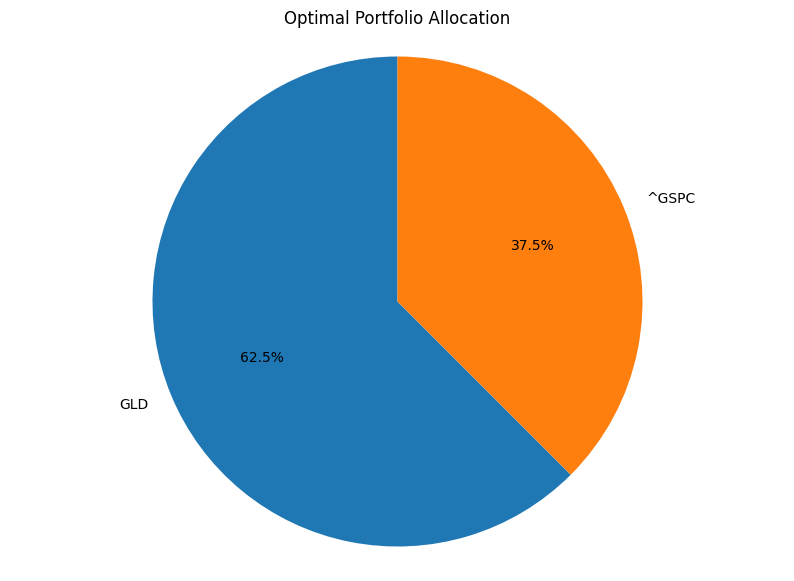

In [38]:
def plot_portfolio_allocation(allocations, tickers):
    """
    Plot the portfolio allocation as a pie chart.
    
    Parameters:
    - allocations: Dictionary mapping asset indices to allocation percentages
    - tickers: List of ticker symbols
    """
    labels = []
    sizes = []
    
    for i, ticker in enumerate(tickers):
        alloc = allocations.get(i, 0)
        if alloc > 0:
            labels.append(ticker)
            sizes.append(alloc)
    
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Optimal Portfolio Allocation')
    plt.show()

# Plot the best allocation
plot_portfolio_allocation(valid_p[0]['allocations'], tickers)


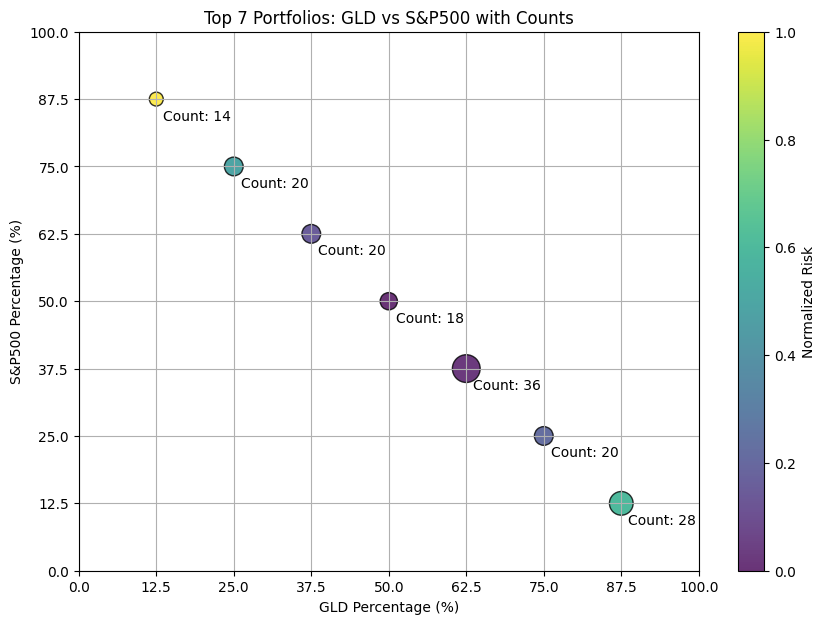

In [40]:
# plotting
x = [p['allocations'].get(0, 0) * 100 for p in valid_p]  # GLD %
y = [p['allocations'].get(1, 0) * 100 for p in valid_p]  # ^GSPC %
risk = [p['risk'] for p in valid_p]
counts = [p['count'] for p in valid_p]

# Normalize risk for color mapping
norm_risk = (np.array(risk) - min(risk)) / (max(risk) - min(risk))

# Normalize counts for size mapping
norm_counts = (np.array(counts) - min(counts)) / (max(counts) - min(counts))

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=norm_risk, s=100 + norm_counts * 300, cmap='viridis', alpha=0.8, edgecolors='black')

# Add colorbar for risk
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Risk')

# Labels and title
plt.xlabel('GLD Percentage (%)')
plt.ylabel('S&P500 Percentage (%)')
plt.title(f"Top {len(valid_p)} Portfolios: GLD vs S&P500 with Counts")

# Set x and y axis limits and ticks
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 101, 12.5))
plt.yticks(np.arange(0, 101, 12.5))

# Annotate points with risk and count
for i, p in enumerate(valid_p):
    plt.annotate(f"Count: {p['count']}", (x[i], y[i]), textcoords="offset points", xytext=(5,-15), ha='left')

plt.grid(True)
plt.show()


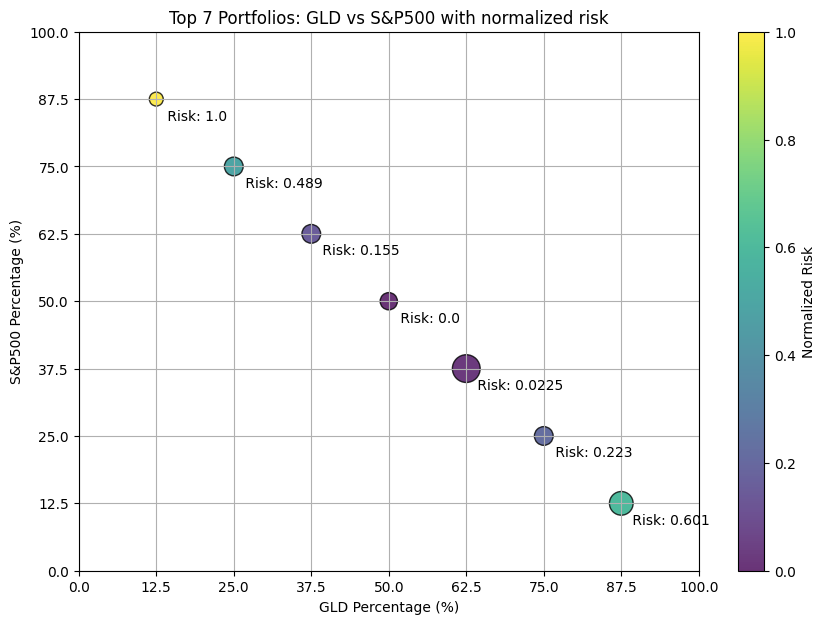

In [44]:
# plotting
x = [p['allocations'].get(0, 0) * 100 for p in valid_p]  # GLD %
y = [p['allocations'].get(1, 0) * 100 for p in valid_p]  # ^GSPC %
risk = [p['risk'] for p in valid_p]
counts = [p['count'] for p in valid_p]

# Normalize risk for color and size mapping
norm_risk = (np.array(risk) - min(risk)) / (max(risk) - min(risk))
norm_counts = (np.array(counts) - min(counts)) / (max(counts) - min(counts))

# sort all arrays by ascending risk
order = np.argsort(risk)
x = np.array(x)[order]
y = np.array(y)[order]
norm_risk = norm_risk[order]
norm_counts = norm_counts[order]
valid_p = [valid_p[i] for i in order]


# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=norm_risk, s=100 + norm_counts * 300, cmap='viridis', alpha=0.8, edgecolors='black')

# Add colorbar for risk
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Risk')

# Labels and title
plt.xlabel('GLD Percentage (%)')
plt.ylabel('S&P500 Percentage (%)')
plt.title(f"Top {len(valid_p)} Portfolios: GLD vs S&P500 with normalized risk")

# Set x and y axis limits and ticks
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 101, 12.5))
plt.yticks(np.arange(0, 101, 12.5))

# Annotate points with risk and count
for i, p in enumerate(valid_p):
    plt.annotate(f" Risk: {norm_risk[i]:.3}", (x[i], y[i]), textcoords="offset points", xytext=(5,-15), ha='left')

plt.grid(True)
plt.show()


In [51]:
y

array([50. , 37.5, 62.5, 25. , 75. , 12.5, 87.5])